# Проект e-commerce

![ecommerce](ecommerce.png)

В данном проекте я буду анализировать данные из e-commerce. Для начала я предварительно исследую данные, сформулирую, что мы будем считать покупкой, посмотрю на пользователей, их заказы и товары в самых разных срезах, а затем проведу когортный и качественный анализы аудитории.

Описание имеющихся данных:

1) olist_customers_dataset.csv — таблица с уникальными идентификаторами пользователей

    customer_id — позаказный идентификатор пользователя

    customer_unique_id —  уникальный идентификатор пользователя  (аналог номера паспорта)

    customer_zip_code_prefix —  почтовый индекс пользователя

    customer_city —  город доставки пользователя

    customer_state —  штат доставки пользователя

2) olist_orders_dataset.csv —  таблица заказов

    order_id —  уникальный идентификатор заказа (номер чека)

    customer_id —  позаказный идентификатор пользователя

    order_status —  статус заказа

    order_purchase_timestamp —  время создания заказа

    order_approved_at —  время подтверждения оплаты заказа

    order_delivered_carrier_date —  время передачи заказа в логистическую службу

    order_delivered_customer_date —  время доставки заказа

    order_estimated_delivery_date —  обещанная дата доставки

3) olist_order_items_dataset.csv —  товарные позиции, входящие в заказы

    order_id —  уникальный идентификатор заказа (номер чека)

    order_item_id —  идентификатор товара внутри одного заказа

    product_id —  ид товара (аналог штрихкода)

    seller_id — ид производителя товара

    shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике

    price —  цена за единицу товара

    freight_value —  вес товара

Уникальные статусы заказов в таблице olist_orders_dataset:

    created —  создан

    approved —  подтверждён

    invoiced —  выставлен счёт

    processing —  в процессе сборки заказа

    shipped —  отгружен со склада

    delivered —  доставлен пользователю

    unavailable —  недоступен

    canceled —  отменён

По этим данным мне предстоит ответить на следующие вопросы:

1. Сколько у нас пользователей, которые совершили покупку только один раз?

2. Сколько заказов в месяц в среднем не доставляется по разным причинам (с детализацией по причинам)?

3. По каждому товару определим, в какой день недели товар чаще всего покупается.

4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не будем забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это учтем.

5. Используя pandas, проведем когортный анализ пользователей. В период с января по декабрь выявим когорту с самым высоким retention на 3й месяц.

6. Используя python, построим RFM-сегментацию пользователей, чтобы качественно оценить нашу аудиторию. В кластеризации выберем следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Для каждого RFM-сегмента построим границы метрик recency, frequency и monetary для интерпретации этих кластеров.

Для решения задачи проведем предварительное исследование данных и сформулируем, что должно считаться покупкой.

![Scheme](Scheme.png)

# Исследовательский анализ данных

In [172]:
#импорт всех необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta 

%matplotlib inline
sns.set()

In [173]:
#считаем данные в pandas DataFrame и сразу же переведем все даты к типу datetime
olist_customers_dataset   = pd.read_csv('olist_customers_dataset.csv')
olist_orders_dataset      = pd.read_csv('olist_orders_dataset.csv',
                                      parse_dates=['order_purchase_timestamp', 'order_approved_at', 
                                                   'order_delivered_carrier_date', 'order_delivered_customer_date',
                                                   'order_estimated_delivery_date'])
olist_order_items_dataset = pd.read_csv('olist_order_items_dataset.csv', parse_dates=['shipping_limit_date'])

Посмотрим на то, как выглядят наши данные

In [174]:
olist_customers_dataset.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [175]:
olist_orders_dataset.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [176]:
olist_order_items_dataset.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


Посмотрим на информацию по столбцам наших таблиц

In [177]:
olist_customers_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [178]:
olist_orders_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 6.1+ MB


In [179]:
olist_order_items_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   order_id             112650 non-null  object        
 1   order_item_id        112650 non-null  int64         
 2   product_id           112650 non-null  object        
 3   seller_id            112650 non-null  object        
 4   shipping_limit_date  112650 non-null  datetime64[ns]
 5   price                112650 non-null  float64       
 6   freight_value        112650 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 6.0+ MB


In [180]:
#посмотрим описательную статистику для числовых переменных в таблице товаров
olist_order_items_dataset.describe()

,order_item_id,price,freight_value
count,112650.000000,112650.000000,112650.000000
mean,1.197834,120.653739,19.990320
std,0.705124,183.633928,15.806405
min,1.000000,0.850000,0.000000
25%,1.000000,39.900000,13.080000
50%,1.000000,74.990000,16.260000
75%,1.000000,134.900000,21.150000
max,21.000000,6735.000000,409.680000


In [181]:
# интересно понимать, за какой период эти данные
olist_orders_dataset.order_purchase_timestamp.min(), olist_orders_dataset.order_purchase_timestamp.max()

(Timestamp('2016-09-04 21:15:19'), Timestamp('2018-10-17 17:30:18'))

Мы видим, что в таблицах olist_customers_dataset и olist_orders_dataset одинаковое число строчек. Попробуем разобраться, почему так.

In [182]:
#Группируем таблицу с заказами по customer_id, подсчитываем количество заказов и сортируем по убыванию
olist_orders_dataset.groupby('customer_id', as_index=False) \
                    .agg(order_id_count=('order_id', 'count')) \
                    .sort_values('order_id_count', ascending=False).head()

,customer_id,order_id_count
0,00012a2ce6f8dcda20d059ce98491703,1
66279,aa62a16b10e3fb24ecdefd7e4dc3fa65,1
66301,aa738cdb72af39e38482fa25b992c67c,1
66300,aa7210736aad65a84e964cfa8d64aa66,1
66299,aa72002446dfbac0691304465c1b982d,1


Так как customer_id - позаказный идентификатор, на один customer_id в таблице olist_orders_dataset приходится один заказ. Понять, сколько у нас уникальных пользователей мы можем по таблице olist_customers_dataset:

In [183]:
olist_customers_dataset.customer_unique_id.nunique()

96096

Теперь давайте разберемся, что мы будем считать покупкой. Для этого посмотрим на уникальные статусы заказов и решим, какие состояния нам подходят.

Статус created

In [184]:
olist_orders_dataset.query('order_status == "created"') #отбор заказов со статусом "создан"

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
7434,b5359909123fa03c50bdb0cfed07f098,438449d4af8980d107bf04571413a8e7,created,2017-12-05 01:07:52,NaT,NaT,NaT,2018-01-11
9238,dba5062fbda3af4fb6c33b1e040ca38f,964a6df3d9bdf60fe3e7b8bb69ed893a,created,2018-02-09 17:21:04,NaT,NaT,NaT,2018-03-07
21441,7a4df5d8cff4090e541401a20a22bb80,725e9c75605414b21fd8c8d5a1c2f1d6,created,2017-11-25 11:10:33,NaT,NaT,NaT,2017-12-12
55086,35de4050331c6c644cddc86f4f2d0d64,4ee64f4bfc542546f422da0aeb462853,created,2017-12-05 01:07:58,NaT,NaT,NaT,2018-01-08
58958,90ab3e7d52544ec7bc3363c82689965f,7d61b9f4f216052ba664f22e9c504ef1,created,2017-11-06 13:12:34,NaT,NaT,NaT,2017-12-01


Мы видим, что у нас всего 5 таких наблюдений. По отсутствию данных в колонке order_approved_at можно сделать вывод, что эти заказы не были подтверждены со стороны магазина. Давайте проверим, что было добавлено в корзину у этих пользователей:

In [185]:
created_orders = olist_orders_dataset.query('order_status == "created"').order_id
olist_order_items_dataset.query('order_id in @created_orders')

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value


Теперь становится ясно, что подтверждения не было по причине того, что эти пользоатели создали пустые заказы.
Вывод: заказы со статусом "created" не являются покупками. 

Статус approved

In [186]:
olist_orders_dataset.query('order_status == "approved"') #отбор заказов со статусом "подтверждён"

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
44897,a2e4c44360b4a57bdff22f3a4630c173,8886130db0ea6e9e70ba0b03d7c0d286,approved,2017-02-06 20:18:17,2017-02-06 20:30:19,NaT,NaT,2017-03-01
88457,132f1e724165a07f6362532bfb97486e,b2191912d8ad6eac2e4dc3b6e1459515,approved,2017-04-25 01:25:34,2017-04-30 20:32:41,NaT,NaT,2017-05-22


In [187]:
# проверяем, есть ли товары в корзине
approved_orders = olist_orders_dataset.query('order_status == "approved"').order_id
olist_order_items_dataset.query('order_id in @approved_orders')

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
8409,132f1e724165a07f6362532bfb97486e,1,c4a1c4638fa9e2e4861d141d6e0259e7,5444b12c82f21c923f2639ebc722c1ea,2017-05-08 20:32:41,169.90,9.56
71423,a2e4c44360b4a57bdff22f3a4630c173,1,dcecb611ba878d5d8c7853585b285c12,8cc6a0e5738e61a87b03c78b2ba9db4b,2017-02-10 20:18:17,19.85,10.96
71424,a2e4c44360b4a57bdff22f3a4630c173,2,dcecb611ba878d5d8c7853585b285c12,8cc6a0e5738e61a87b03c78b2ba9db4b,2017-02-10 20:18:17,19.85,10.96


Два непустых заказа, которые были подтверждены, но по какой-то причине для них не был выставлен счет. 
Вывод: заказы со статусом "approved" не являются покупками. 

Статус invoiced

In [188]:
olist_orders_dataset.query('order_status == "invoiced"').head() #отбор заказов со статусом "выставлен счёт"

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaT,NaT,2017-05-09
103,0760a852e4e9d89eb77bf631eaaf1c84,d2a79636084590b7465af8ab374a8cf5,invoiced,2018-08-03 17:44:42,2018-08-07 06:15:14,NaT,NaT,2018-08-21
455,38b7efdf33dd5561f4f5d4f6e07b0414,021e84751ba0ead75b6d314a6ead88d9,invoiced,2017-08-01 18:17:41,2017-08-01 18:32:30,NaT,NaT,2017-08-28
1833,51b0dccc8596ce37a930dff2d63a10a2,31bf1057b00f14804278590bbac18b1b,invoiced,2017-05-05 22:34:48,2017-05-05 22:45:12,NaT,NaT,2017-06-06
2116,5504eaa5a86eb25fa666cf2e6b96c701,a30be38e1ed0ffb39b318bf1d15e98d9,invoiced,2017-11-29 08:33:06,2017-11-29 08:56:23,NaT,NaT,2017-12-20


In [189]:
olist_orders_dataset.query('order_status == "invoiced"').shape[0]

314

Заказы со статусом "invoiced" по всей видимости не были оплачены и как следствие не были переданы на сборку. Их также не имеет смысла принимать за покупки.

Статус processing

In [190]:
olist_orders_dataset.query('order_status == "processing"').head() #отбор заказов со статусом "в процессе сборки заказа"

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
128,15bed8e2fec7fdbadb186b57c46c92f2,f3f0e613e0bdb9c7cee75504f0f90679,processing,2017-09-03 14:22:03,2017-09-03 14:30:09,NaT,NaT,2017-10-03
324,d3c8851a6651eeff2f73b0e011ac45d0,957f8e082185574de25992dc659ebbc0,processing,2016-10-05 22:44:13,2016-10-06 15:51:05,NaT,NaT,2016-12-09
741,6a6c7d523fd59eb5bbefc007331af717,d954782ec6c0e911292c8a80757ef28d,processing,2017-11-24 20:09:33,2017-11-24 23:15:15,NaT,NaT,2017-12-20
1192,745e1d4a7f8c4b548881788d4113bb1d,7198d7088442e4ddfe553353d8ddc957,processing,2017-11-17 06:34:36,2017-11-18 02:15:40,NaT,NaT,2017-12-12
1516,1d52ba7197c7acebbb4f826f6585536f,c9c7fe860d602373a9e93f8bfe9d877a,processing,2017-02-13 18:32:55,2017-02-13 18:43:55,NaT,NaT,2017-04-04


In [191]:
olist_orders_dataset.query('order_status == "processing"').shape[0]

301

Заказы, которые начали собирать, но так и не выгрузили со склада. Возможно в процессе сборки обнаружилось отсутствие каких-либо товаров из корзины. Так как у нас нет информации о возвратах, мы не можем выяснить, что случилось с ними в дальнейшем. В любом случае, за покупку их считать мы не можем.

Статус shipped

In [192]:
olist_orders_dataset.query('order_status == "shipped"').head() #отбор заказов со статусом "отгружен со склада"

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
44,ee64d42b8cf066f35eac1cf57de1aa85,caded193e8e47b8362864762a83db3c5,shipped,2018-06-04 16:44:48,2018-06-05 04:31:18,2018-06-05 14:32:00,NaT,2018-06-28
154,6942b8da583c2f9957e990d028607019,52006a9383bf149a4fb24226b173106f,shipped,2018-01-10 11:33:07,2018-01-11 02:32:30,2018-01-11 19:39:23,NaT,2018-02-07
162,36530871a5e80138db53bcfd8a104d90,4dafe3c841d2d6cc8a8b6d25b35704b9,shipped,2017-05-09 11:48:37,2017-05-11 11:45:14,2017-05-11 13:21:47,NaT,2017-06-08
231,4d630f57194f5aba1a3d12ce23e71cd9,6d491c9fe2f04f6e2af6ec033cd8907c,shipped,2017-11-17 19:53:21,2017-11-18 19:50:31,2017-11-22 17:28:34,NaT,2017-12-13
299,3b4ad687e7e5190db827e1ae5a8989dd,1a87b8517b7d31373b50396eb15cb445,shipped,2018-06-28 12:52:15,2018-06-28 13:11:09,2018-07-04 15:20:00,NaT,2018-08-03


In [193]:
olist_orders_dataset.query('order_status == "shipped"').shape[0]

1107

Давайте проверим, нет ли заказов которые были отгружены со склада и их обещанная дата доставки выходит за временные границы наших исторических данных (заказы, которые еще могли не доставить на момент анализа). За максимальную дату я приму максимальную дату доставки заказа.

In [194]:
max_date = olist_orders_dataset.order_delivered_customer_date.max()
olist_orders_dataset.query('order_status == "shipped" and order_estimated_delivery_date > @max_date')

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date


Таких примеров нет, а значит заказы со статусом "shipped" - это заказы, не дошедшие до наших клиентов. Также не являются покупкой.

Статус delivered

In [195]:
olist_orders_dataset.query('order_status == "delivered"').head() #отбор заказов со статусом "доставлен пользователю"

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [196]:
olist_orders_dataset.query('order_status == "delivered"').shape[0]

96478

И наконец, заказы, которые были успешно доставлены до клиентов. Они составляют большую часть наших данных. Их мы и будем считать за покупки. Отмененные (canceled) и недоступные (unavailable) заказы по своей природе выбывают из этой категории.

Теперь, когда мы опеределили, что является покупкой, попробуем ответить на поставленные вопросы.

# Сколько у нас пользователей, которые совершили покупку только один раз?

Для того, чтобы это выяснить сделаем слияние таблиц с пользователями и заказами, отберем те заказы, которые были доставлены, сгруппируем по уникальному id покупателя и применим агрегирующую функцию count(), а затем подсчитаем количество при помощи value_counts().

In [197]:
# делаем inner join
df_cust_order = olist_customers_dataset.merge(olist_orders_dataset, how='inner', on='customer_id')

In [198]:
# группировка и агрегация
orders_count = df_cust_order.query('order_status == "delivered"') \
             .groupby('customer_unique_id', as_index=False) \
             .agg(orders_count=('order_id', 'count')) \
             .orders_count.value_counts()

<function seaborn.utils.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=False, offset=None, trim=False)>

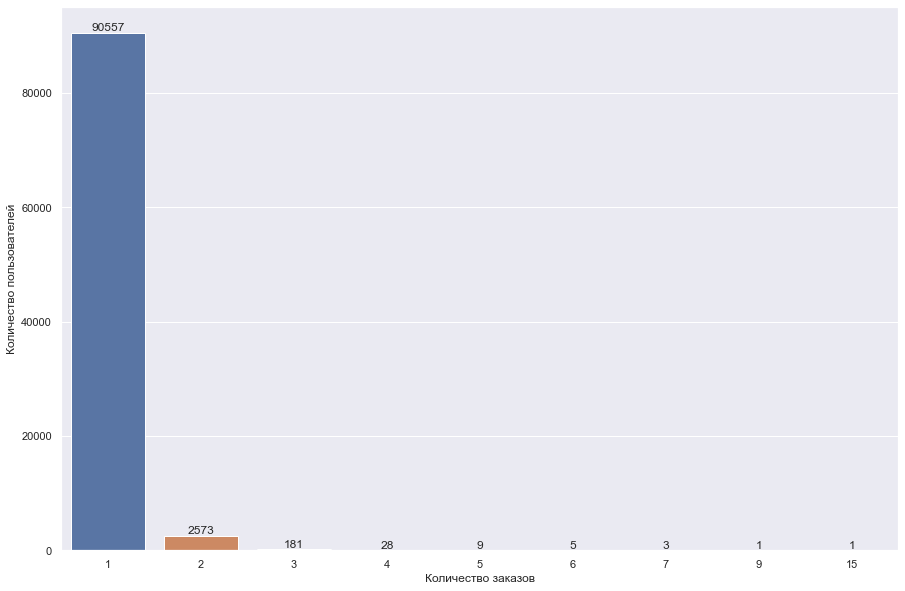

In [199]:
# визуализируем результат
plt.figure(figsize=(15,10))
ax = sns.barplot(x=orders_count.index, y=orders_count.values)
ax.bar_label(ax.containers[0])
ax.set_xlabel('Количество заказов')
ax.set_ylabel('Количество пользователей')

sns.despine

Итак, у нас 90557 пользователей, которые совершили покупку только один раз.

# Сколько заказов в месяц в среднем не доставляется по разным причинам (с детализацией по причинам)?

Чтобы ответить на этот вопрос, сгруппируем данные о заказах по статусам для подсчета их количества, а затем разделим на количество месяцев.

In [200]:
# создадим колонку с округленными значениями дат создания заказа до месяца
olist_orders_dataset['order_purchase_year_month'] = olist_orders_dataset['order_purchase_timestamp'] \
                                                                        .astype('datetime64[M]')

In [201]:
# количество месяцев
month_count = olist_orders_dataset.order_purchase_year_month.nunique()

In [202]:
# группировка и агрегация
order_status_count = olist_orders_dataset.query('order_status != "delivered"') \
                    .groupby('order_status', as_index=False) \
                    .agg(not_delivered_count =('order_id', 'count'))

In [203]:
order_status_count.head()

,order_status,not_delivered_count
0,approved,2
1,canceled,625
2,created,5
3,invoiced,314
4,processing,301


In [204]:
# а теперь подсчет среднего
order_status_count['not_delivered_avg'] = order_status_count['not_delivered_count'] / month_count

In [205]:
order_status_count

,order_status,not_delivered_count,not_delivered_avg
0,approved,2,0.08
1,canceled,625,25.00
2,created,5,0.20
3,invoiced,314,12.56
4,processing,301,12.04
5,shipped,1107,44.28
6,unavailable,609,24.36


Выведем детализацию по причинам

<function seaborn.utils.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=False, offset=None, trim=False)>

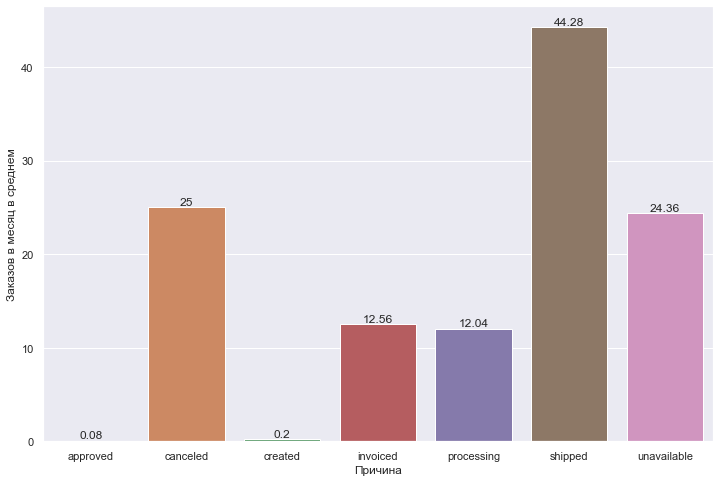

In [206]:
# визуализируем результат
plt.figure(figsize=(12,8))
ax = sns.barplot(data=order_status_count, x='order_status', y='not_delivered_avg')
ax.bar_label(ax.containers[0])
ax.set_xlabel('Причина')
ax.set_ylabel('Заказов в месяц в среднем')

sns.despine

# По каждому товару определим, в какой день недели товар чаще всего покупается. 

Поджойним таблицы с заказами и товарами, отберем те заказы, что были доставлены, а за дату покупки примем дату создания заказа(не беру дату подтверждения оплаты, так как в данных есть случаи, когда подтверждение произошло после доставки товара клиенту)

In [207]:
# left join
df_order_items = olist_orders_dataset.merge(olist_order_items_dataset, how='left', on='order_id') \
                                     .query('order_status == "delivered"')

In [208]:
# создаем колонку с названиями дней недели
df_order_items['purchase_weekday'] = df_order_items['order_purchase_timestamp'].dt.day_name()

In [209]:
# группируем по id товара и дню недели
df_id_weekday = df_order_items.groupby(['product_id', 'purchase_weekday'], as_index=False) \
              .agg(count=('order_id', 'count'))

In [210]:
# применяем оконную функцию с партицией по id товара для создания колонки с максимальным количеством покупок 
df_id_weekday['max_count'] = df_id_weekday.groupby('product_id')['count'].transform(max)

In [211]:
# отбираем только те строки, где счетчик совпадает с максимальным
df_id_weekday_max = df_id_weekday.query('count == max_count')

In [212]:
# Проверяем, что для одного продукта может быть несколько дней недели с максимальным кол-м покупок 
# (количество строк не равно количеству уникальных product_id)
df_id_weekday_max.product_id.nunique() == df_id_weekday_max.shape[0]

False

Я объединю дни недели для каждого продукта в список для более наглядного представления:

In [213]:
df_id_weekday_max.groupby('product_id', as_index=False).agg({'purchase_weekday': list})

,product_id,purchase_weekday
0,00066f42aeeb9f3007548bb9d3f33c38,[Sunday]
1,00088930e925c41fd95ebfe695fd2655,[Tuesday]
2,0009406fd7479715e4bef61dd91f2462,[Thursday]
3,000b8f95fcb9e0096488278317764d19,"[Friday, Wednesday]"
4,000d9be29b5207b54e86aa1b1ac54872,[Tuesday]
...,...,...
32211,fff6177642830a9a94a0f2cba5e476d1,"[Saturday, Sunday]"
32212,fff81cc3158d2725c0655ab9ba0f712c,[Monday]
32213,fff9553ac224cec9d15d49f5a263411f,[Friday]
32214,fffdb2d0ec8d6a61f0a0a0db3f25b441,[Tuesday]


Для каждого товара мы определили, в какой(какие) день(дни) недели его покупают чаще всего.

# Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Помним о том, что внутри месяца может быть не целое количество недель. 

Сделаем необходимые объединения таблиц:

In [214]:
# импорт библиотеки для нахождения количества дней в месяце
from calendar import monthrange

In [215]:
# делаем inner join
df_cust_order = olist_customers_dataset.merge(olist_orders_dataset, how='inner', on='customer_id')

# проведем фильтрацию по статусу заказа
df_cust_order = df_cust_order.query('order_status == "delivered"')

In [216]:
df_cust_order.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_year_month
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,2017-05-01
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,2018-01-01
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,2018-05-01
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,2018-03-01
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,2018-07-01


Теперь, когда в одном DataFrame мы получили всю информацию: уникальный id пользователя, год-месяц каждого заказа, мы можем подсчитать метрику для каждого пользователя в отдельности, а затем усреднить по всем покупателям.

In [217]:
# группируем по месяцам и уникальным id пользователя, считаем количество покупок в месяц
df_month_user_id_count = df_cust_order.groupby(['order_purchase_year_month', 'customer_unique_id'], as_index=False) \
                                           .agg(orders_count=('order_id', 'count'))

In [218]:
# создаем столбец с количеством недель в месяце создания заказа
df_month_user_id_count['weeks_month'] = df_month_user_id_count['order_purchase_year_month'] \
                                                       .apply(lambda x: monthrange(x.year, x.month)[1]) / 7

In [219]:
# подсчет метрики по каждому клиенту в отдельности
df_month_user_id_count['avg_purchase_by_week_by_user'] = (df_month_user_id_count['orders_count'] / 
                                                          df_month_user_id_count['weeks_month'])

In [220]:
df_month_user_id_count.head()

,order_purchase_year_month,customer_unique_id,orders_count,weeks_month,avg_purchase_by_week_by_user
0,2016-09-01,830d5b7aaa3b6f1e9ad63703bec97d23,1,4.285714,0.233333
1,2016-10-01,0032c76b20340da25249092a268ce66c,1,4.428571,0.225806
2,2016-10-01,01f156677184504063bd19739f924af1,1,4.428571,0.225806
3,2016-10-01,0636d30c77f0f9cfad81f1c9b58c791f,1,4.428571,0.225806
4,2016-10-01,06bdfbbe1857c3c925ec81abfb1c9666,1,4.428571,0.225806


In [221]:
# группировка по месяцам и рассчет метрики по всем пользователям
df_month_avg = df_month_user_id_count.groupby('order_purchase_year_month', as_index=False) \
                      .agg(avg_purchase_by_week_by_month=('avg_purchase_by_week_by_user', 'mean'))

In [222]:
df_month_avg

,order_purchase_year_month,avg_purchase_by_week_by_month
0,2016-09-01,0.233333
1,2016-10-01,0.228392
2,2016-12-01,0.225806
3,2017-01-01,0.235870
4,2017-02-01,0.253528
5,2017-03-01,0.229228
6,2017-04-01,0.236309
7,2017-05-01,0.230155
8,2017-06-01,0.237809
9,2017-07-01,0.229964


Text(0, 0.5, 'Среднее количество покупок в неделю')

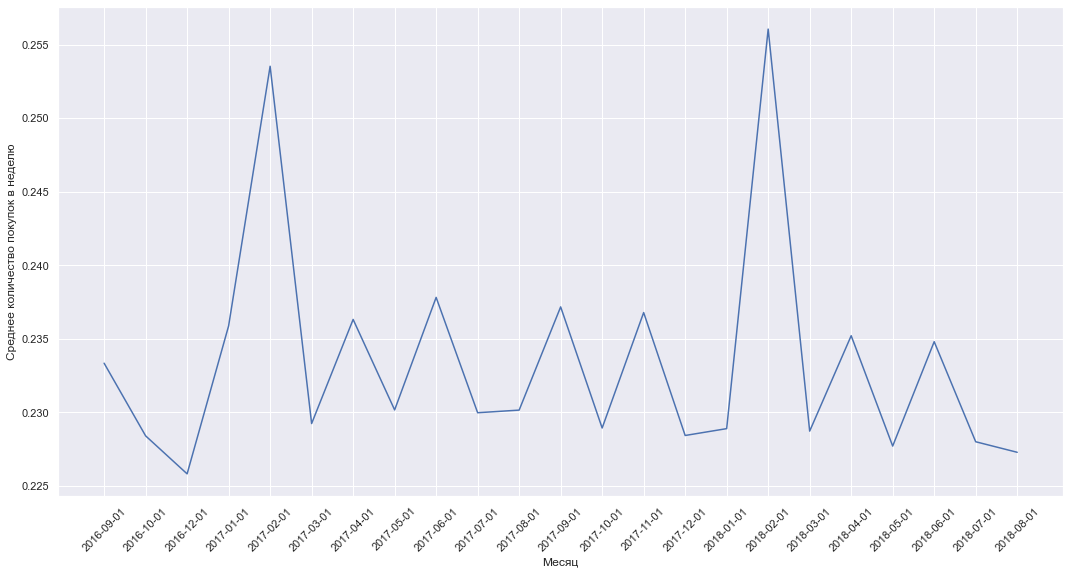

In [223]:
# визуализация
plt.figure(figsize=(18, 9))
ax = sns.lineplot(x=df_month_avg['order_purchase_year_month'].astype(str), y=df_month_avg['avg_purchase_by_week_by_month'])
ax.tick_params(axis='x', labelrotation=45)
ax.set_xlabel('Месяц')
ax.set_ylabel('Среднее количество покупок в неделю')

С чем связаны всплески в феврале 2017 и феврале 2018?

In [224]:
# проверим записи о покупках
df_month_user_id_count.query('order_purchase_year_month == "2017-02-01"').head()

,order_purchase_year_month,customer_unique_id,orders_count,weeks_month,avg_purchase_by_week_by_user
982,2017-02-01,002b4cd83fabaffaa475f78ea5ef3e08,1,4.0,0.25
983,2017-02-01,0087eede471173af78d789df249c3a45,1,4.0,0.25
984,2017-02-01,012b8001e47392df808a454083a74b74,1,4.0,0.25
985,2017-02-01,01469c41b00bb21cd01d2104b8e81384,1,4.0,0.25
986,2017-02-01,016feebfaba953a2456d3a063b8eb8ef,1,4.0,0.25


In [225]:
df_month_user_id_count.query('order_purchase_year_month == "2018-02-01"').head()

,order_purchase_year_month,customer_unique_id,orders_count,weeks_month,avg_purchase_by_week_by_user
49972,2018-02-01,00053a61a98854899e70ed204dd4bafe,1,4.0,0.25
49973,2018-02-01,00196fdb2bf9edfc35e88ebfbcf8d781,1,4.0,0.25
49974,2018-02-01,0019da6aa6bcb27cc32f1249bd12da05,1,4.0,0.25
49975,2018-02-01,002aba8c1af80acacef6e011f9f23262,1,4.0,0.25
49976,2018-02-01,002ef00822613c94613e60e03b169fef,1,4.0,0.25


Так как в феврале 28 дней, что умещает в себя ровно 4 недели, при усреднении мы получили немного завышенную метрику. Проверим есть ли разница в процентном соотношении между количеством покупок в феврале 2017 и например апреле 2017.

In [226]:
df_month_user_id_count.query('order_purchase_year_month == "2017-02-01"').orders_count.value_counts(normalize=True)

1    0.987730
2    0.011043
4    0.000613
3    0.000613
Name: orders_count, dtype: float64

In [227]:
df_month_user_id_count.query('order_purchase_year_month == "2017-04-01"').orders_count.value_counts(normalize=True)

1    0.988566
2    0.010554
4    0.000440
3    0.000440
Name: orders_count, dtype: float64

Сильных различий нет, а значит на графике мы видим всплеск из-за особенностей метода расчета данной метрики.

# Проведем когортный анализ пользователей. В период с января по декабрь выявим когорту с самым высоким retention на 3й месяц.

Сперва определим параметры когортного анализа. Так как мы смотрим на ключевой показатель retention, в качестве признака формирования когорты возьмем первый заказ клиента. Размер когорты - месяц, отчетный период: январь 2017 - декабрь 2017

In [228]:
# отберем только доставленные заказы и объединим таблицы
df_order_customer = olist_orders_dataset.query('order_status == "delivered"') \
                                        .merge(olist_customers_dataset, how='inner', on='customer_id')

In [229]:
# отберем заказы, совершенные в 2017 году
df_order_customer = df_order_customer[df_order_customer.order_purchase_timestamp.dt.year == 2017]

In [230]:
# создадим колонку с месяцем первого заказа для каждого уникального клиента
df_order_customer['cohort'] = df_order_customer \
                                                .groupby('customer_unique_id')['order_purchase_timestamp'] \
                                                .transform(min).astype('datetime64[M]')

In [231]:
df_order_customer.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_year_month,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,cohort
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2017-10-01,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2017-09-01
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,2017-11-01,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,2017-11-01
5,a4591c265e18cb1dcee52889e2d8acc3,503740e9ca751ccdda7ba28e9ab8f608,delivered,2017-07-09 21:57:05,2017-07-09 22:10:13,2017-07-11 14:58:04,2017-07-26 10:57:55,2017-08-01,2017-07-01,80bb27c7c16e8f973207a5086ab329e2,86320,congonhinhas,PR,2017-07-01
6,6514b8ad8028c9f2cc2374ded245783f,9bdf08b4b3b52b5526ff42d37d47f222,delivered,2017-05-16 13:10:30,2017-05-16 13:22:11,2017-05-22 10:07:46,2017-05-26 12:55:51,2017-06-07,2017-05-01,932afa1e708222e5821dac9cd5db4cae,26525,nilopolis,RJ,2017-05-01
7,76c6e866289321a7c93b82b54852dc33,f54a9f0e6b351c431402b8461ea51999,delivered,2017-01-23 18:29:09,2017-01-25 02:50:47,2017-01-26 14:16:31,2017-02-02 14:08:10,2017-03-06,2017-01-01,39382392765b6dc74812866ee5ee92a7,99655,faxinalzinho,RS,2017-01-01


In [232]:
# группировка по когорте и месяцу заказа, подсчет уникальных клиентов
retention = df_order_customer.groupby(['cohort', 'order_purchase_year_month'], as_index=False) \
                             .agg(count=('customer_unique_id', 'count'))

In [233]:
# применяем оконную функцию для подсчета долей от количества новых клиентов в первый месяц
retention['count'] = retention['count'] / retention.groupby('cohort')['count'].transform(max)

In [234]:
# переименовываем колонки, назначаем индексы
retention.rename(columns={'order_purchase_year_month': 'cohort_period', 'count': 'user_retention_by_cohort'}, inplace=True)
retention.set_index(['cohort', 'cohort_period'], inplace=True)

In [235]:
# строим сводную таблицу
retention = retention.pivot_table(index='cohort', columns='cohort_period')

In [236]:
retention

user_retention_by_cohort                                   \
cohort_period               2017-01-01 2017-02-01 2017-03-01 2017-04-01   
cohort                                                                    
2017-01-01                         1.0   0.002667   0.002667   0.001333   
2017-02-01                         NaN   1.000000   0.001817   0.003028   
2017-03-01                         NaN        NaN   1.000000   0.004723   
2017-04-01                         NaN        NaN        NaN   1.000000   
2017-05-01                         NaN        NaN        NaN        NaN   
2017-06-01                         NaN        NaN        NaN        NaN   
2017-07-01                         NaN        NaN        NaN        NaN   
2017-08-01                         NaN        NaN        NaN        NaN   
2017-09-01                         NaN        NaN        NaN        NaN   
2017-10-01                         NaN        NaN        NaN        NaN   
2017-11-01                         NaN        NaN        NaN        NaN   
2017-12-01                         NaN        NaN        NaN        NaN   

                                                                      \
cohort_period 2017-05-01 2017-06-01 2017-07-01 2017-08-01 2017-09-01   
cohort                                                                 
2017-01-01      0.004000   0.001333   0.004000   0.001333   0.001333   
2017-02-01      0.001211   0.004240   0.001211   0.002423   0.001817   
2017-03-01      0.003542   0.004723   0.003542   0.001574   0.001574   
2017-04-01      0.006565   0.002626   0.002188   0.002626   0.002626   
2017-05-01      1.000000   0.004834   0.004549   0.002843   0.002843   
2017-06-01           NaN   1.000000   0.005175   0.004204   0.004204   
2017-07-01           NaN        NaN   1.000000   0.005758   0.003402   
2017-08-01           NaN        NaN        NaN   1.000000   0.007017   
2017-09-01           NaN        NaN        NaN        NaN   1.000000   
2017-10-01           NaN        NaN        NaN        NaN        NaN   
2017-11-01           NaN        NaN        NaN        NaN        NaN   
2017-12-01           NaN        NaN        NaN        NaN        NaN   

                                                
cohort_period 2017-10-01 2017-11-01 2017-12-01  
cohort                                          
2017-01-01           NaN   0.004000   0.001333  
2017-02-01      0.001211   0.001817   0.001211  
2017-03-01      0.003148   0.003148   0.000787  
2017-04-01      0.003939   0.003063   0.003063  
2017-05-01      0.003412   0.004549   0.001422  
2017-06-01      0.003234   0.003881   0.003558  
2017-07-01      0.002355   0.003402   0.002094  
2017-08-01      0.003871   0.002662   0.003387  
2017-09-01      0.006878   0.005404   0.003685  
2017-10-01      1.000000   0.007527   0.002509  
2017-11-01           NaN   1.000000   0.005865  
2017-12-01           NaN        NaN   1.000000

Мы можем ответить на поставленный вопрос по этой таблице, но для наглядности проведем некоторые преобразования:

In [237]:
#Теперь создадим колонку с номером месяца жизни клиента, чтобы посмотреть на retention в более удобном формате
df_order_customer['lifetime'] = (
((df_order_customer['order_purchase_year_month'] - df_order_customer['cohort']) / np.timedelta64(1, 'M')) \
                                                                            .round().astype(int))

In [238]:
# проделаем все те же самые операции
retention = df_order_customer.groupby(['cohort', 'lifetime'], as_index=False) \
                             .agg(count=('customer_unique_id', 'count'))

In [239]:
retention['count'] = retention['count'] / retention.groupby('cohort')['count'].transform(max)

In [240]:
# перевод колонки cohort к типу string для отсечки нулей в datetime64
retention['cohort'] = retention['cohort'].astype('str')

In [241]:
retention.rename(columns={'lifetime': 'cohort_period', 'count': 'user_retention_by_cohort'}, inplace=True)
retention.set_index(['cohort', 'cohort_period'], inplace=True)

In [242]:
retention = retention.pivot_table(index='cohort', columns='cohort_period')

In [243]:
# визуализация
ur_style = (retention
            .style
            .background_gradient(cmap='viridis')  # раскрашиваем ячейки по столбцам
            .highlight_null('white')  # делаем белый фон для значений NaN
            .format("{:.2%}", na_rep=""))  # числа форматируем как проценты, NaN заменяем на пустоту
ur_style

Вывод:
Из таблицы видно, что когорта с самым высоким retention на 3 месяц это клиенты, сделавшие первый заказ в марте 2017 года (2017-03-01)

# RFM-сегментация пользователей

В качестве метрик выберем следующие показатели:

R - время от последней покупки пользователя до текущей даты, в качестве текущей даты возьмем следующий день после даты последнего заказа

F - суммарное количество покупок у пользователя за всё время 

M - сумма покупок за всё время



In [244]:
# производим фильтрацию и джоины всех таблиц в одну, так мы получим информацию о каждом товаре каждого заказа каждого клиента
df_order_customer_item = olist_orders_dataset.query('order_status == "delivered"') \
                    .merge(olist_customers_dataset, how='inner', on='customer_id') \
                    .merge(olist_order_items_dataset, how='left', on='order_id')

In [245]:
# группируем по каждому заказу и считаем общую сумму
df_order_customer_price = df_order_customer_item \
                      .groupby(['order_id', 'customer_unique_id', 'order_purchase_timestamp'], as_index=False) \
                      .agg({'price': 'sum'})

In [246]:
df_order_customer_price.head()

,order_id,customer_unique_id,order_purchase_timestamp,price
0,00010242fe8c5a6d1ba2dd792cb16214,871766c5855e863f6eccc05f988b23cb,2017-09-13 08:59:02,58.90
1,00018f77f2f0320c557190d7a144bdd3,eb28e67c4c0b83846050ddfb8a35d051,2017-04-26 10:53:06,239.90
2,000229ec398224ef6ca0657da4fc703e,3818d81c6709e39d06b2738a8d3a2474,2018-01-14 14:33:31,199.00
3,00024acbcdf0a6daa1e931b038114c75,af861d436cfc08b2c2ddefd0ba074622,2018-08-08 10:00:35,12.99
4,00042b26cf59d7ce69dfabb4e55b4fd9,64b576fb70d441e8f1b2d7d446e483c5,2017-02-04 13:57:51,199.90


In [247]:
# дата последнего заказа
NOW = df_order_customer_price.order_purchase_timestamp.max() + timedelta(days=1)

In [248]:
# в каждой строке найдем разницу между датой заказа и текущей датой 
df_order_customer_price['days_since_order'] = (NOW - df_order_customer_price.order_purchase_timestamp).dt.days

Теперь мы для каждого пользователя можем найти  R, F и M. R в нашем случае - это минимальное значение колонки days_since_order, F - количество заказов за все время, M - сумма по всему столбцу price.

In [249]:
# пропишем агрегирующие функции в одном словаре
agg = {
    'days_since_order' : 'min',
    'order_id': 'count',
    'price': 'sum'
}

In [250]:
# производим группировку
df_rfm = df_order_customer_price.groupby('customer_unique_id', as_index=False).agg(agg)

In [251]:
df_rfm.rename(columns={'days_since_order': 'Recency', 'order_id': 'Frequency', 'price': 'Monetary'}, inplace=True)

In [252]:
df_rfm.head()

,customer_unique_id,Recency,Frequency,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90
2,0000f46a3911fa3c0805444483337064,537,1,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99
4,0004aac84e0df4da2b147fca70cf8255,288,1,180.00


Посмотрим на квантили распределений наших метрик

In [253]:
quintiles = df_rfm[['Recency', 'Frequency', 'Monetary']].quantile([.2, .4, .6, .8]).to_dict()
quintiles

{'Recency': {0.2: 92.0, 0.4: 177.0, 0.6: 268.0, 0.8: 382.0},
 'Frequency': {0.2: 1.0, 0.4: 1.0, 0.6: 1.0, 0.8: 1.0},
 'Monetary': {0.2: 39.9, 0.4: 69.9, 0.6: 109.9, 0.8: 179.9}}

In [254]:
df_rfm['Frequency'].quantile([.96, .97, .98, .999])

0.960    1.00
0.970    1.29
0.980    2.00
0.999    3.00
Name: Frequency, dtype: float64

Видим, что около 96% всех наших клиентов совершили только 1 заказ, при этом в разное время и с разной суммой. Поэтому будет логично взять 2 градации для фактора F: 1 - пользователь совершил 1 заказ, 2 - пользователь совершил более 1 заказа. Для метрик R и M я возьму оценки от 1 до 5 в соответствии с квантилями распределений

In [255]:
# чем меньше время с последнего заказа, тем больше оценка
def r_score(x):
    if x <= quintiles['Recency'][.2]:
        return 5
    elif x <= quintiles['Recency'][.4]:
        return 4
    elif x <= quintiles['Recency'][.6]:
        return 3
    elif x <= quintiles['Recency'][.8]:
        return 2
    else:
        return 1

In [256]:
# сегмент пользователей с 1 заказом имеет оценку 1, более 1 заказа - 2
def f_score(x):
    if x == 1:
        return 1
    elif x > 1:
        return 2

In [257]:
# чем больше сумма всех покупок, тем выше оценка
def m_score(x):
    if x <= quintiles['Monetary'][.2]:
        return 1
    elif x <= quintiles['Monetary'][.4]:
        return 2
    elif x <= quintiles['Monetary'][.6]:
        return 3
    elif x <= quintiles['Monetary'][.8]:
        return 4
    else:
        return 5 

In [258]:
df_rfm['R'] = df_rfm['Recency'].apply(lambda x: r_score(x))
df_rfm['F'] = df_rfm['Frequency'].apply(lambda x: f_score(x))
df_rfm['M'] = df_rfm['Monetary'].apply(lambda x: m_score(x))

In [259]:
# создадим объединенную колонку RFM_score
df_rfm['RFM_Score'] = df_rfm['R'].map(str) + df_rfm['F'].map(str) + df_rfm['M'].map(str)

In [260]:
df_rfm.head()

,customer_unique_id,Recency,Frequency,Monetary,R,F,M,RFM_Score
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90,4,1,4,414
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90,4,1,1,411
2,0000f46a3911fa3c0805444483337064,537,1,69.00,1,1,2,112
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99,2,1,1,211
4,0004aac84e0df4da2b147fca70cf8255,288,1,180.00,2,1,5,215


Так как у нас по 5 оценок для R и M и две оценки для F, мы имеем 5 * 5 * 2 = 50 комбинаций. Я буду рассматривать сегменты на основе R и M рейтингов. Это позволит выявить клиентов которые приносят больше всего прибыли и тех, чей вклад в общую прибыль незначителен.

![RM_segments](RM-segments.png)

Для того, чтобы разобраться, насколько важен для нас показатель R(есть ли разница между пользователем, который совершил покупку на одну и ту же сумму год назад или вчера при условии, что 96% клиентов не возвращаются) давайте изучим поведение людей с повторными заказами.

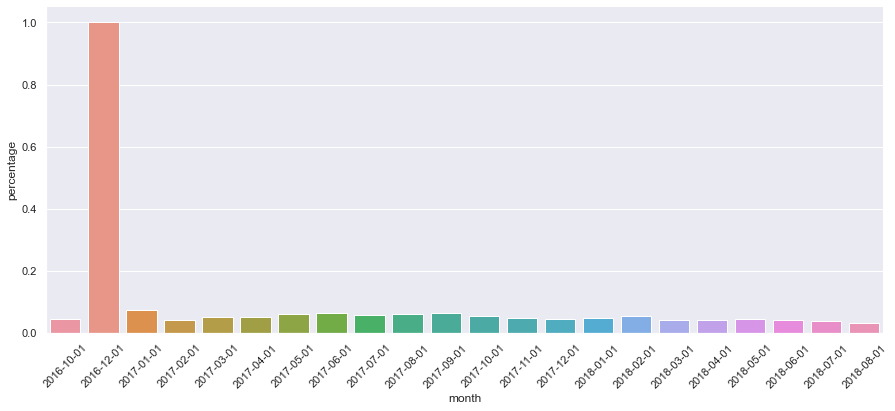

In [261]:
# доля вернувшихся по месяцам

# создадим колонку с месяцем заказа
df_order_customer_price['month'] = df_order_customer_price.order_purchase_timestamp.astype('datetime64[M]').astype('str')

more_freq_id = df_rfm[df_rfm.F == 2].customer_unique_id # id пользователей с рейтингом F равным 2

# количество всех пользователей по месяцам
all_cust_per_mon = df_order_customer_price.groupby('month', as_index=False).customer_unique_id.nunique() 

# количество вернувшихся пользователей по месяцам
more_freq_cust_per_mon = df_order_customer_price.query('customer_unique_id in @more_freq_id') \
            .groupby('month', as_index=False) \
            .customer_unique_id.nunique()

# считаем долю без учета сентября 2016 года(оттуда нет ни одного вернувшегося)
percentage_per_mon = (more_freq_cust_per_mon.set_index('month') / all_cust_per_mon[1:].set_index('month')).reset_index()

# визуализация
plt.figure(figsize=(15, 6))
sns.barplot(data=percentage_per_mon, x='month', y='customer_unique_id')
plt.ylabel('percentage')
plt.xticks(rotation=45)
sns.despine()

In [262]:
# посмотрим на выброс
df_order_customer_price.query('month == "2016-12-01"')

,order_id,customer_unique_id,order_purchase_timestamp,price,days_since_order,month
71323,bd50a7fe9fd97ea4b7663031a319e150,f7b981e8a280e455ac3cbe0d5d171bd1,2016-12-23 23:16:47,10.9,614,2016-12-01


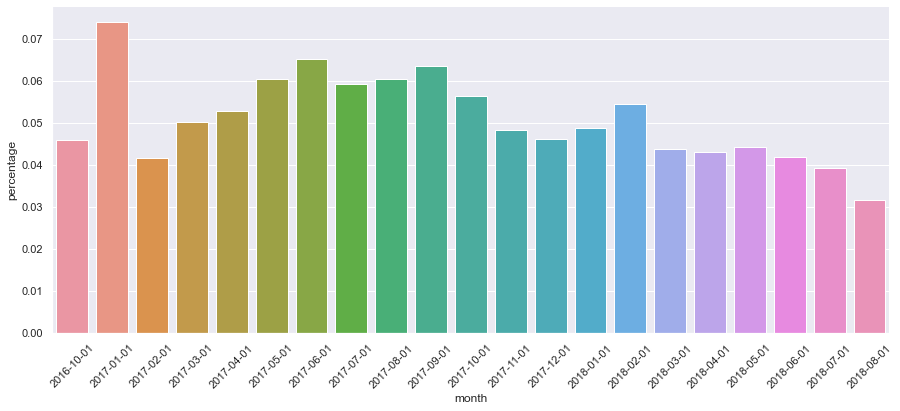

In [263]:
plt.figure(figsize=(15, 6))
sns.barplot(data=percentage_per_mon.query('month != "2016-12-01"'), x='month', y='customer_unique_id')
plt.ylabel('percentage')
plt.xticks(rotation=45)
sns.despine()

В январе 2016 был совершен только один заказ вернувшимся пользователем, поэтому на первом графике наблюдается аномалия. В остальном распределение равномерное, что заставляет задуматься о продуктовом значении R оценки для данного магазина на этом этапе развития.

Опишем сегменты в продуктовых терминах и создадим колонку с названиями

![RM-segments_in_term](RM-segments_in_term.png)

In [264]:
# словарь для замены цифр на названия сегментов с помощью регулярных выражений
segt_dict = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2]3': 'about to sleep',
    r'[1-2][4-5]': 'promising',
    r'3[1-2]': 'at risk',
    r'33': 'need attention',
    r'3[4-5]': 'potential loyalists',
    r'[4-5][1-2]': 'can\'t loose',
    r'[4-5]3': 'loyal customers',
    r'[4-5][4-5]': 'champions'
}

In [265]:
df_rfm['Segment'] = df_rfm['R'].map(str) + df_rfm['M'].map(str)
df_rfm['Segment'] = df_rfm['Segment'].replace(segt_dict, regex=True)
df_rfm.head()

,customer_unique_id,Recency,Frequency,Monetary,R,F,M,RFM_Score,Segment
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90,4,1,4,414,champions
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90,4,1,1,411,can't loose
2,0000f46a3911fa3c0805444483337064,537,1,69.00,1,1,2,112,hibernating
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99,2,1,1,211,hibernating
4,0004aac84e0df4da2b147fca70cf8255,288,1,180.00,2,1,5,215,promising


Построим визуализацию нашего RFM анализа

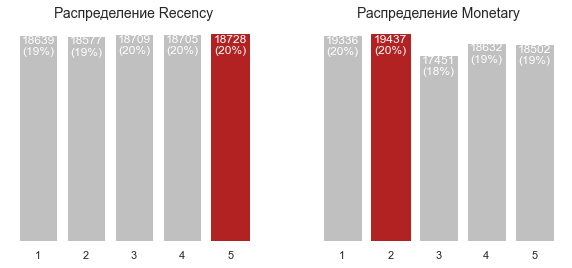

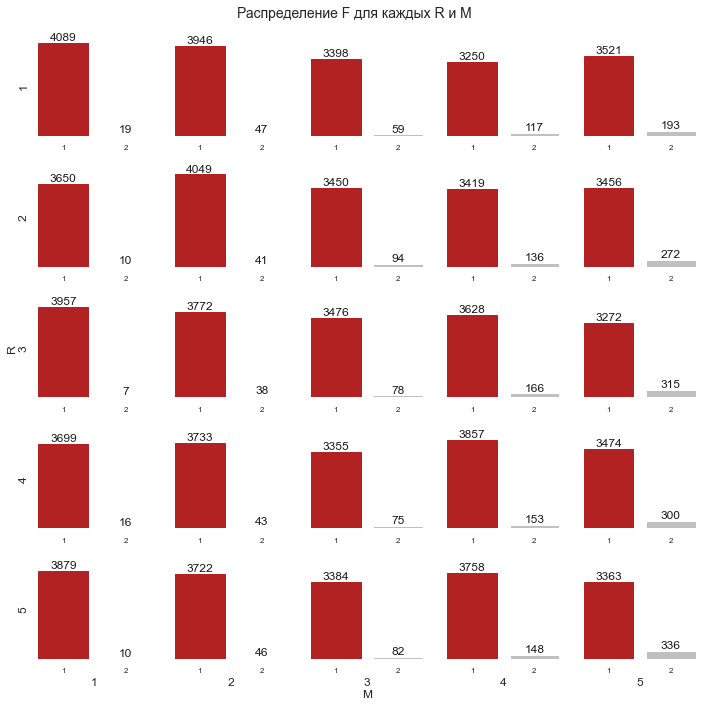

In [266]:
# строим распределение клиентов по R и M оценкам
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

for i, p in enumerate(['R', 'M']):
    parameters = {'R':'Recency', 'M':'Monetary'}
    y = df_rfm[p].value_counts().sort_index()
    x = y.index
    ax = axes[i]
    bars = ax.bar(x, y, color='silver')
    ax.set_frame_on(False)
    ax.tick_params(left=False, labelleft=False, bottom=False)
    ax.set_title('Распределение {}'.format(parameters[p]),
                fontsize=14)
    for bar in bars:
        value = bar.get_height()
        if value == y.max():
            bar.set_color('firebrick')
        ax.text(bar.get_x() + bar.get_width() / 2,
                value - 5,
                '{}\n({}%)'.format(int(value), int(value * 100 / y.sum())),
               ha='center',
               va='top',
               color='w')

plt.show()

# строим распределение F оценки в зависимости от RM рейтинга
fig, axes = plt.subplots(nrows=5, ncols=5,
                         sharex=False, sharey=True,
                         figsize=(10, 10))

r_range = range(1, 6)
m_range = range(1, 6)
for r in r_range:
    for m in m_range:
        y = df_rfm[(df_rfm['R'] == r) & (df_rfm['M'] == m)]['F'].value_counts().sort_index()
        x = y.index
        ax = axes[r - 1, m - 1]
        bars = ax.bar(x, y, color='silver')
        if r == 5:
            if m == 3:
                ax.set_xlabel('{}\nM'.format(m), va='top')
            else:
                ax.set_xlabel('{}\n'.format(m), va='top')
        if m == 1:
            if r == 3:
                ax.set_ylabel('R\n{}'.format(r))
            else:
                ax.set_ylabel(r)
        ax.set_frame_on(False)
        ax.tick_params(left=False, labelleft=False, bottom=False)
        ax.set_xticks(x)
        ax.set_xticklabels(x, fontsize=8)

        for bar in bars:
            value = bar.get_height()
            if value == y.max():
                bar.set_color('firebrick')
            ax.text(bar.get_x() + bar.get_width() / 2,
                    value,
                    int(value),
                    ha='center',
                    va='bottom',
                    color='k')
fig.suptitle('Распределение F для каждых R и M',
             fontsize=14)
plt.tight_layout()
plt.show()

Распределения оценок R и M равномерные. Можно заметить интересную тенденцию: клиенты, покупающие на большую сумму, чаще делают более одного заказа. Значит сумма покупки могла бы служить нам ориентиром, стоит ли тратить деньги на попытку завлечь пользователя повторно или нет.

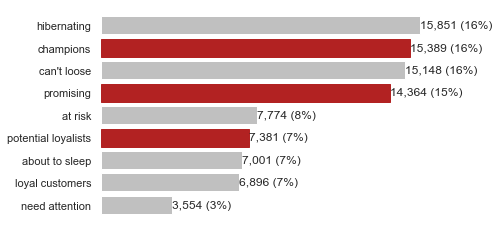

In [267]:
# подсчитываем количество клиентов в каждом сегменте
segments_counts = df_rfm['Segment'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()

bars = ax.barh(range(len(segments_counts)),
              segments_counts,
              color='silver')
ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)

for i, bar in enumerate(bars):
        value = bar.get_width()
        if segments_counts.index[i] in ['champions', 'potential loyalists', 'promising']:
            bar.set_color('firebrick')
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:}%)'.format(int(value),
                                   int(value*100/segments_counts.sum())),
                va='center',
                ha='left'
               )

plt.show()

Красным выделены сегменты с наибольшей метрикой M. Вклад этих пользователей в общую прибыль наибольший, а также они чаще делают повторные заказы. Далее мы могли бы разработать подходы по взаимодействию с ними и попробовать разобраться с тем, чем клиенты с большим чеком отличаются от клиентов с маленьким и как перевести вторых в первых.

# Заключение

Итак, в данном проекте я исследовал данные из e-commerce, выгрузил и изучил датасеты, осмыслил описание колонок и взаимосвязь между таблицами. Самостоятельно определил, что является покупкой и обосновал свой выбор. Я постарался изучить и объяснить все аномалии в данных, а также сформировать выводы по заданиям. Провел когортный и сегментный анализы пользователей, описал подход и результаты.